In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Background

This starts with a version of the Dipy Tracking Quickstart Tutorial (http://nipy.org/dipy/examples_built/tracking_quick_start.html#example-tracking-quick-start) for beginners to python. We then go through two more advanced methods for working with streamline data: Quickbundles (link) and Recobundles (link).

NOTE: For this tutorial, we assume you have eddy-corrected (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy) (and if you can susceptibility-corrected; https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup) your data

For more examples:
http://nipy.org/dipy/examples_built/

## Set Up:
To set up:
    
        git clone https://github.com/kesshijordan/dipy_workshop.git
        cd dipy_workshop
        conda install -c conda-forge dipy
        pip install vtk
        pip install nilearn
        jupyter notebook

Download templates from my dropbox:
https://www.dropbox.com/sh/6w1bh1vvmyfq5ss/AAAAH9qSineU8Z3Bo941350Wa?dl=0

# Download and Load our data 
(if we don't have it already)

In [3]:
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
fetch_stanford_hardi()
img, gtab = read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/kesshijordan/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/kesshijordan/.dipy/stanford_hardi 


In [4]:
data = img.get_data()

Let's check and see if our files match our expectations

In [5]:
print(data.shape)

(81, 106, 76, 160)


our data is 81 x 106 voxel resolution in-plane, 76 slices, and 160 volumes

In [6]:
print(gtab.bvals)

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000.]


... and we have our bvalues... 10 b0 volumes (no diffusion weighting) followed by 150 b2000 volumes

In [7]:
print(gtab.bvecs.shape)

(160, 3)


... and the shape of our bvecs make sense... 160 gradients by 3 dimenstions (xyz)

# Save a B0 image

Pick the first B0 image

In [8]:
import numpy as np

index_of_first_B0 = np.where(gtab.b0s_mask)[0][0]
index_of_first_B0

0

Good... we saw from our list that the first volume is a b0 image so this matches our expectation

Now let's extract the first volume from our 4-D dataset

In [9]:
b0_array = data[:,:,:,index_of_first_B0]

... and save it as a nifti

In [10]:
from dipy.io.image import save_nifti

save_nifti('ohbm_dipy_b0.nii.gz', b0_array, img.affine)

# Do a quick brain segmentation

Note: the brain segmentation default parameters don't work, so we use specific ones here. On your own data, try the defaults first

In [11]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, 3, 2, False,
                             vol_idx=range(0, 50))

Now let's save the mask to our current directory

In [12]:
save_nifti('ohbm_dipy_mask.nii.gz', mask*1, img.affine)

Now we will use nilearn plotting to check our mask

In [13]:
import nilearn.plotting as nip

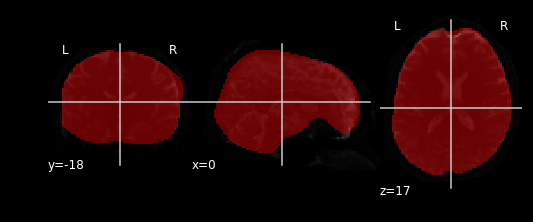

In [14]:
nip.plot_roi('ohbm_dipy_mask.nii.gz', bg_img='ohbm_dipy_b0.nii.gz', 
             cmap=nip.cm.bwr_r, alpha=0.4)

# Fit a Tensor Model

In [15]:
from dipy.reconst.dti import TensorModel

tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(data, mask)

Now let's calculate fractional anisotropy (FA)

In [16]:
fa = tensor_fit.fa

# clip FA values to between 0 and 1
fa = np.clip(fa, 0, 1)

# save the nifti file
save_nifti('ohbm_dipy_fa.nii.gz', fa, img.affine)

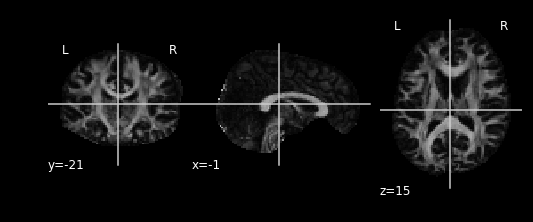

In [17]:
nip.plot_anat('ohbm_dipy_fa.nii.gz')

Now let's visualize the tensor fit using the visualization tools

In [18]:
from dipy.viz import actor, window
from dipy.reconst.dti import color_fa
from dipy.data import get_sphere

ren = window.Renderer()
rgb = color_fa(fa, tensor_fit.evecs)
    
evals = tensor_fit.evals[:,:,28:29]
evecs = tensor_fit.evecs[:, :, 28:29]
cfa = rgb[:, :, 28:29]
cfa /= cfa.max()

sphere = get_sphere('symmetric724') # we need a sphere for the render
ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, 
                                sphere=sphere, scale=0.3))
# Save a snapshot as a png
window.record(ren, n_frames=1, out_path='ohbm_dipy_ren_ten.png', 
              size=(600, 600))

# Uncomment to show this interactively
#window.show(ren)

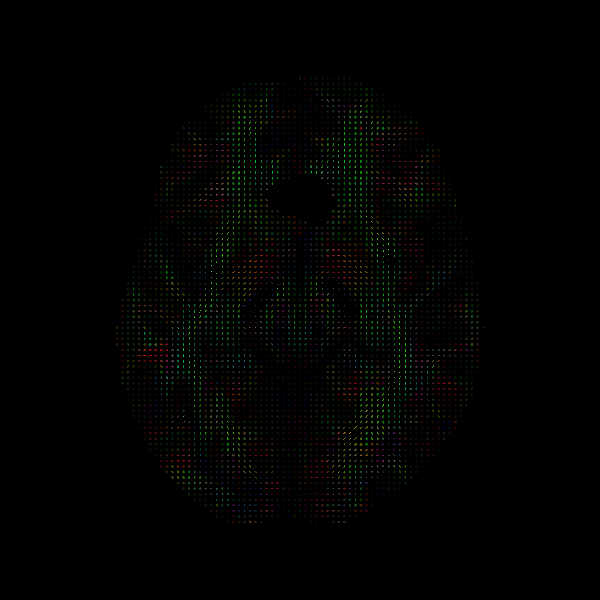

In [19]:
# this will display snapshots inline so we can see our results
from IPython.display import Image

Image('ohbm_dipy_ren_ten.png')

# Fit a "higher order" more complex model

Examples of this are :
- Constrained Spherical Deconvolution (CSD) 
- Constant Solid Angle (CSA)/QBall Model.

First, we estimate a response function for CSD...

The response function is an estimation based on the data of the signal produced by a single coherent bundle of fibers. We will use voxels with very high FA to generate this from our data.

In [20]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.csdeconv import auto_response

response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

# Fit the data and calculate the peaks 

(we assume these are the dominant fiber directions)

In [21]:
from dipy.direction import peaks_from_model

csd_peaks = peaks_from_model(model=csd_model,
                             data=data,
                             sphere=sphere,
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

Check out our peaks on an axial slice by running this cell... a window will pop up 


In [22]:
# Make the rendering with the peaks
window.clear(ren)
ren = window.Renderer()
ren.add(actor.peak_slicer(csd_peaks.peak_dirs,
                          csd_peaks.peak_values,colors=None))

# Uncomment this to interact with the render (a window will pop up)
#window.show(ren, size=(900, 900))

window.record(ren, out_path='ohbm_dipy_peaks.png', size=(900, 900))

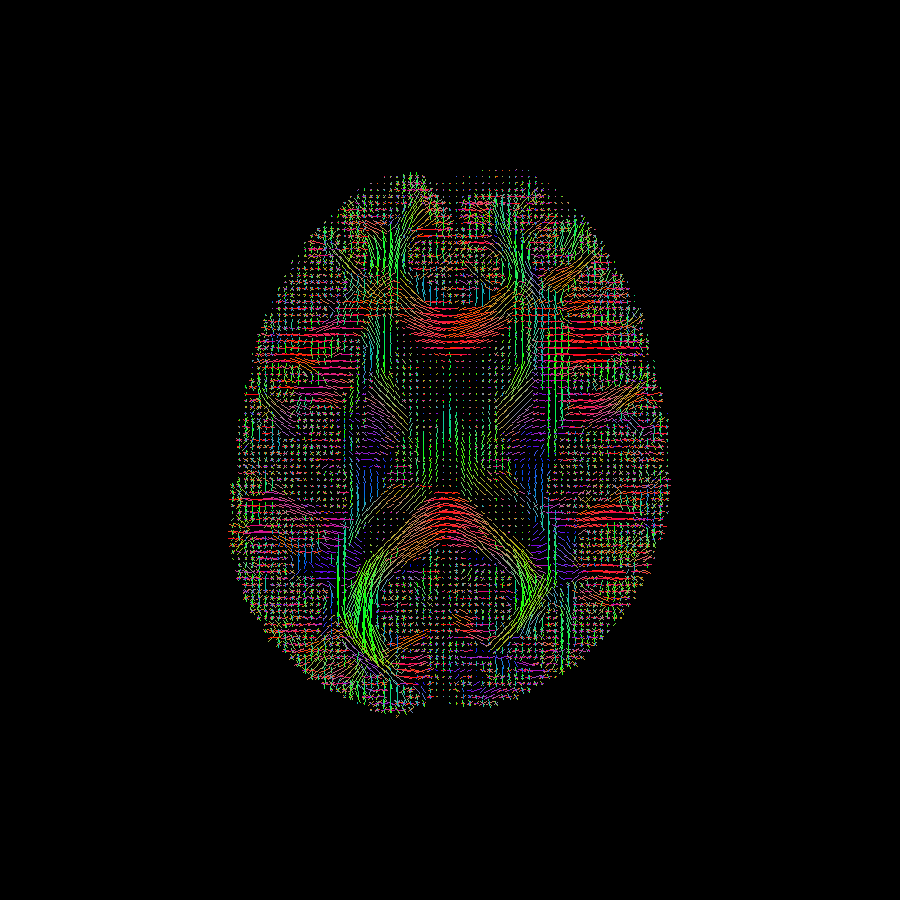

In [23]:
Image('ohbm_dipy_peaks.png')


In [24]:
window.clear(ren)

Looking at the renders... what kinds of model limitations do we encounter with the tensor model?

# Tractography!!

Make a simple tissue classifier (gray/white/csf) using FA

In [25]:
from dipy.tracking.local import ThresholdTissueClassifier

tissue_classifier = ThresholdTissueClassifier(fa, 0.15)

Generate seeds to track from in voxels with high FA... Let's seed all of the voxels with FA greater than 0.3 with one seed

In [26]:
from dipy.tracking.utils import random_seeds_from_mask

seeds = random_seeds_from_mask(fa > 0.3, seeds_count=1)

In [27]:
from dipy.tracking.local import LocalTracking
from dipy.tracking.streamline import Streamlines

streamline_generator = LocalTracking(csd_peaks, tissue_classifier,
                                     seeds, affine=np.eye(4),
                                     step_size=0.5)

streamlines = Streamlines(streamline_generator)

Now let's check how many streamlines we generated

In [28]:
print(len(streamlines))

78631


We can take a look at our streamlines now... let's write a function for this

In [29]:
def show_sls(streamlines, out_path='ohbm_dipy_bigcluster.png', interact=False):    
    ren = window.Renderer()
    
    ren.add(actor.line(streamlines))

    if interact:
        window.show(ren, size=(900, 900))
    
    window.record(ren, out_path=out_path, size=(900, 900))
    return out_path

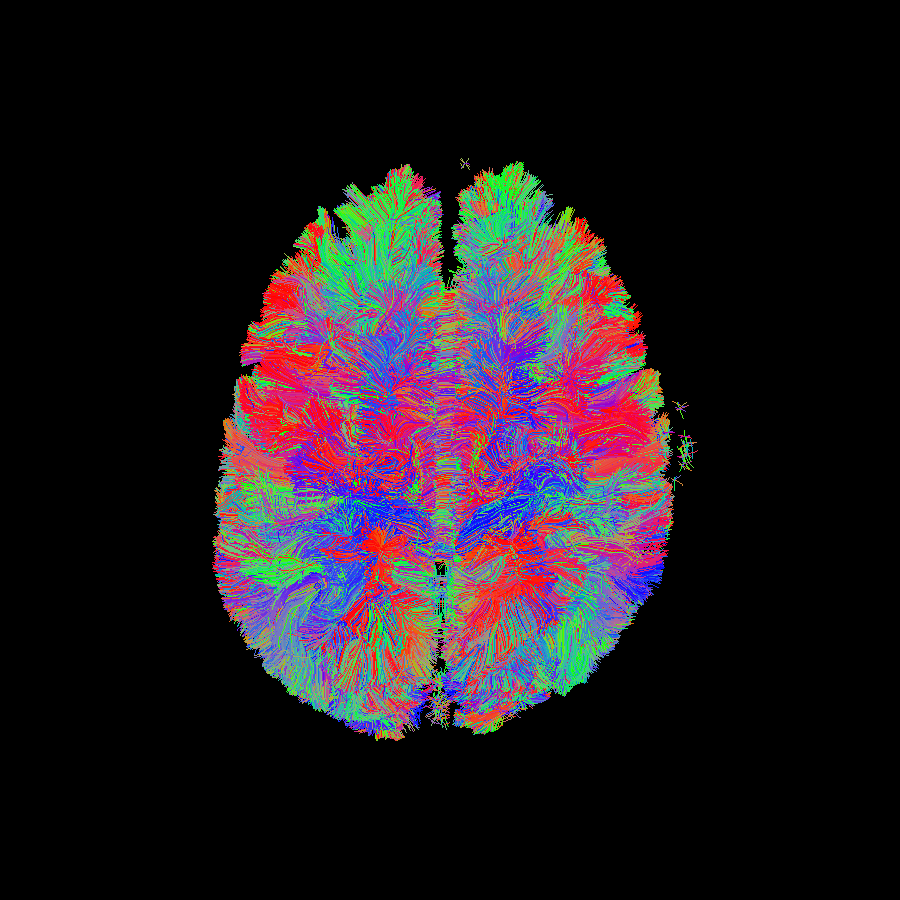

In [30]:
Image(show_sls(streamlines))

Save our wholebrain tractography dataset as a .trk file

This streamline dataset contains many streamlines that we are not interested in... there is sometimes a shell of short streamlines around the periphery of the brain that we know are an artifact of our tracking procedure... in this case we just have a few where the mask fit was poor... we can remove them with a length threshold

Text(0,0.5,'Count')

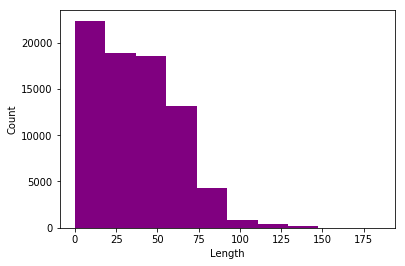

In [31]:
# Calculate the length of each streamline in the dataset
from dipy.tracking.utils import length

lengths = list(length(streamlines))

import matplotlib.pyplot as plt

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='purple')
ax.set_xlabel('Length')
ax.set_ylabel('Count')

In [32]:
# Set a length threshold
length_threshold = 20
long_streamlines = [] # initialize an empty list
for i,sl in enumerate(streamlines):
    if lengths[i] > length_threshold:
        long_streamlines.append(sl)

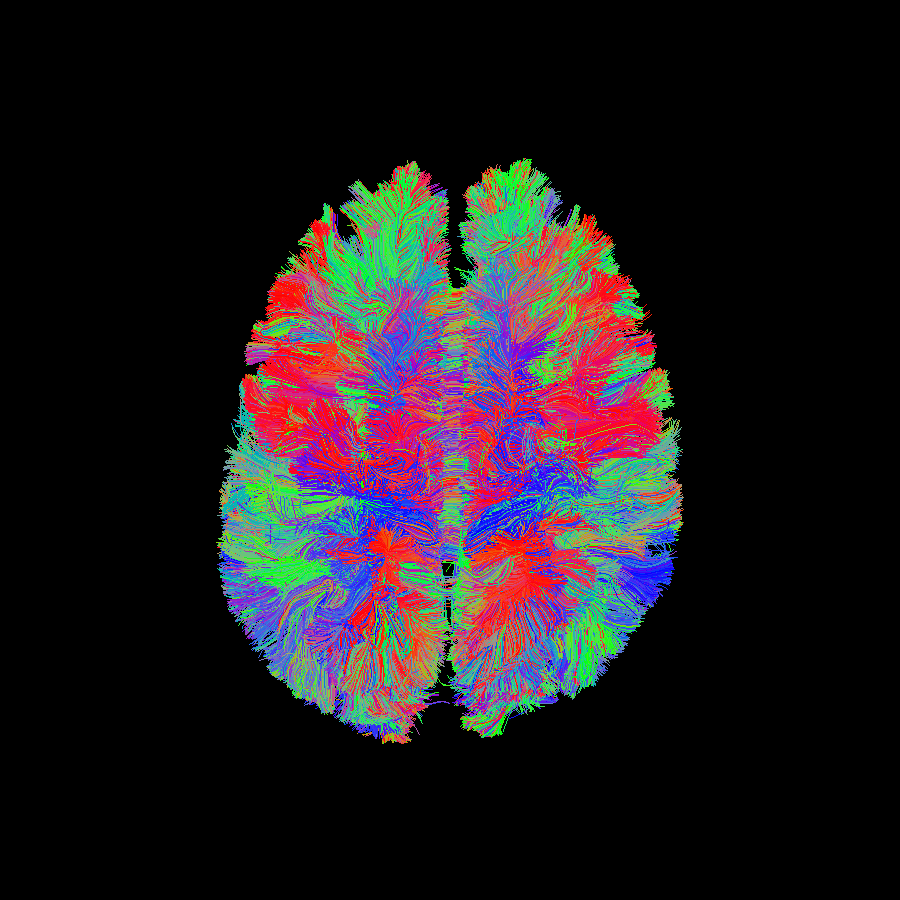

In [33]:
Image(show_sls(long_streamlines))

Save our new track

In [34]:
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram

save_trk(Tractogram(long_streamlines, affine_to_rasmm=img.affine),
         'ohbm_dipy_det_streamlines_long.trk')

# Explore our results with Quickbundles

In [35]:
from dipy.segment.clustering import QuickBundles

In [36]:
qb = QuickBundles(threshold=6.)
clusters = qb.cluster(streamlines)
print(len(clusters), "Clusters")

1919 Clusters


Let's take a look at the centroids...

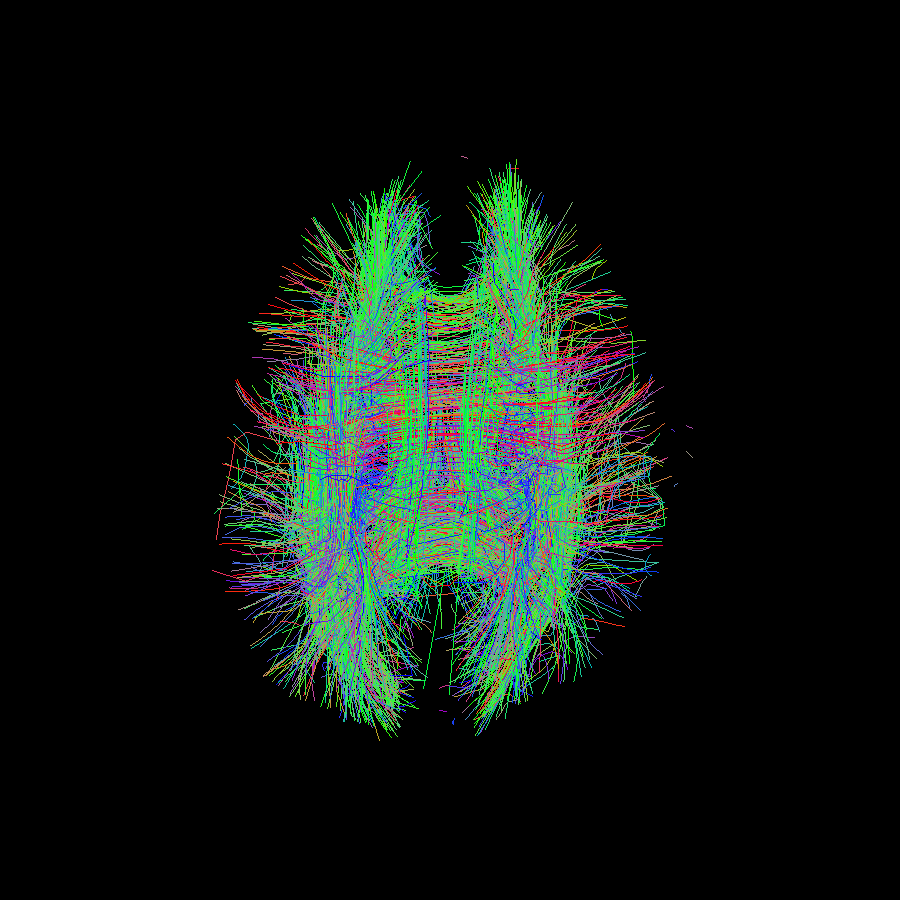

In [37]:
Image(show_sls(clusters.centroids))

Text(0,0.5,'Count')

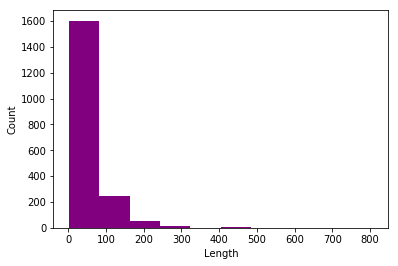

In [38]:
clsz = [len(cl) for cl in clusters]

fig_hist, ax = plt.subplots(1)
ax.hist(clsz, color='purple')
ax.set_xlabel('Length')
ax.set_ylabel('Count')

Let's take a look at our biggest cluster

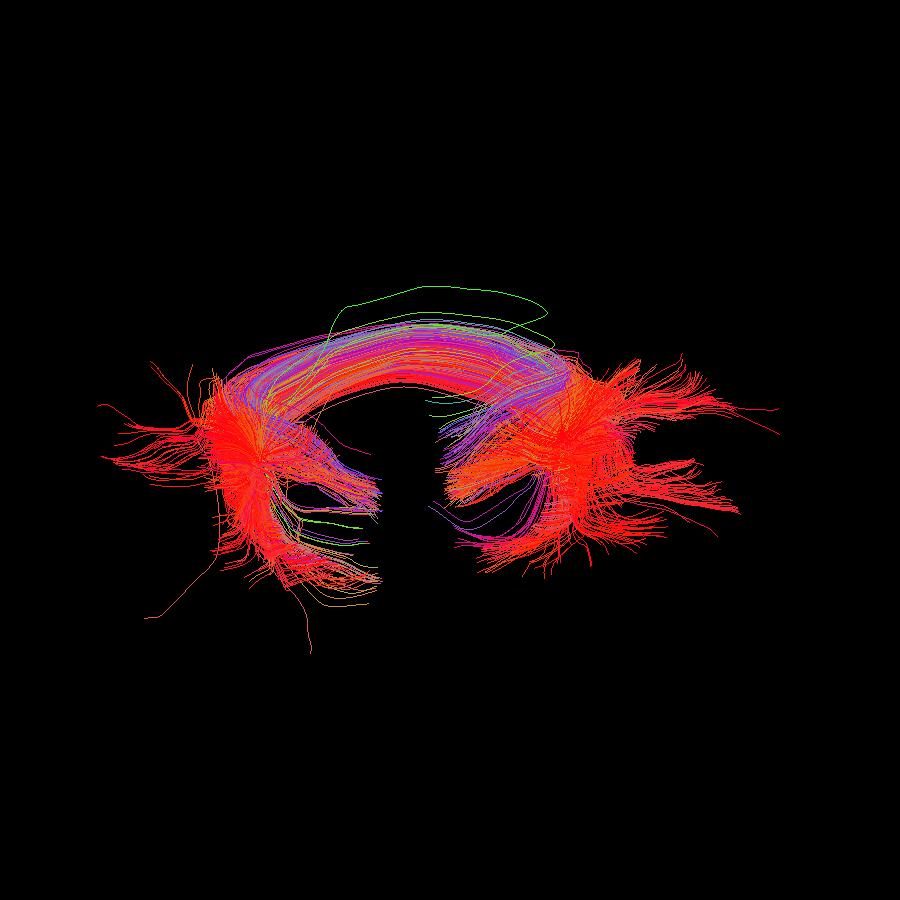

In [39]:
Image(show_sls(clusters[np.argmax(clsz)], interact=False))

# Recobundles

Let's try to automatically segment the CST using Recobundles... to do this we need to use the new nibabel streamline API 

In [40]:
template_path_wb = '../OHBM_DIPY_TUTORIAL_DATA/kesh_template_Wholebrain.trk'
template_path_bundle = '../OHBM_DIPY_TUTORIAL_DATA/kesh_template_ArcuateL.trk'

In [41]:
from dipy.align.streamlinear import whole_brain_slr, slr_with_qb, transform_streamlines

This is a function that will load a .trk file using the new nibabel streamline API

In [42]:
def loadtgm_newapi(trkpath):
    trkloaded = nib.streamlines.trk.TrkFile.load(trkpath)
    hdrloaded = trkloaded.header
    tg=trkloaded.tractogram
    return tg

Let's load our bundle atlas (in this case it's the left Arcuate)

In [43]:
import nibabel as nib

temp_atlasbundle_tg = loadtgm_newapi(template_path_bundle)
temp_atlasbundle_sls = temp_atlasbundle_tg.streamlines
temp_atlasbundle_as = nib.streamlines.array_sequence.ArraySequence(temp_atlasbundle_sls)

Now we'll make a function to display streamlines

In [44]:
def genren(sls, sls2=None, niidata=None, roi1=None, roi2=None, rotx=-90, rotz=90, aff=None, putpath=None, interact=False, orient=True, colors=[(1,1,1)]):
    
    renderer = window.Renderer()
    
    if len(colors)>1:
        stream_actor = actor.line(sls, colors=colors[1])
    else:
        stream_actor=actor.line(sls)
    stream_actor.RotateX(rotx)
    stream_actor.RotateZ(rotz)
    renderer.add(stream_actor)
    
    if sls2 is not None:
        stream_actor2 = actor.line(sls2, colors=colors[0])
        stream_actor2.RotateX(rotx)
        stream_actor2.RotateZ(rotz)
        renderer.add(stream_actor2)
    
    if roi1 is not None and roi2 is not None:
        
        contour_actor1 = actor.contour_from_roi(roi1, affine=aff, color=(1., 1., 0.),
                                          opacity=0.5)
        contour_actor2 = actor.contour_from_roi(roi2, affine=aff, color=(1., 0., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor1)
        renderer.add(contour_actor2)
        
    
    if niidata is not None:
        slice_actor = actor.slicer(niidata, affine=aff)
        renderer.add(slice_actor)

    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #                    focal_point=(113.30, 128.31, 76.56),
    #                    view_up=(0.18, 0.00, 0.98))

    if orient:
        axes_actor = actor.axes(scale=(10, 10, 10), colorx=(1, 0, 0), colory=(0, 1, 0), colorz=(0, 0, 1), opacity=1)
        #Create an actor with the coordinate’s system axes where red = x, green = y, blue = z.
        renderer.add(axes_actor)

    if interact:
        window.show(renderer, size=(600, 600), reset_camera=False)
    if putpath is not None:
        window.record(renderer, out_path=putpath, size=(600, 600))
    del renderer
    return putpath

Display our bundle template

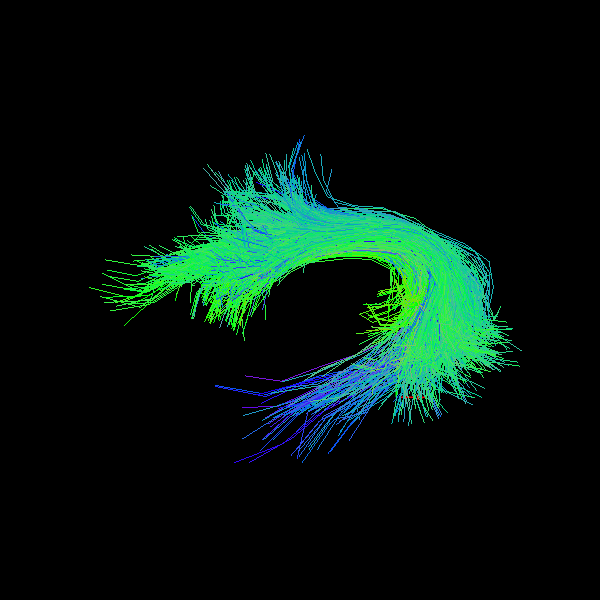

In [45]:
Image(genren(temp_atlasbundle_sls, putpath='ohbm_dipy_adv_atlasbundle.png', interact=False))

Load and display our whole-brain template

In [46]:
temp_wb_tg = loadtgm_newapi(template_path_wb)
temp_wb_sls = temp_wb_tg.streamlines
temp_wb_sls_as = nib.streamlines.array_sequence.ArraySequence(temp_wb_sls)

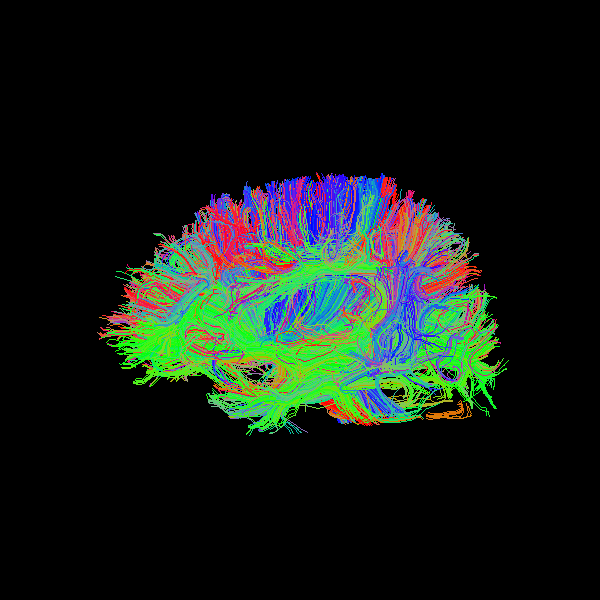

In [47]:
Image(genren(temp_wb_sls, putpath='ohbm_dipy_adv_atlaswb.png'))

Load the wholebrain streamline dataset we generated earlier in the tutorial

In [48]:
sub_wb_tg = loadtgm_newapi('ohbm_dipy_det_streamlines_long.trk')
sub_wb_sls = sub_wb_tg.streamlines
sub_wb_sls_as = nib.streamlines.array_sequence.ArraySequence(sub_wb_sls)

Make a function to roughly register the template-space wholebrain dataset and the subject-space wholebrain dataset we want to extract the Arcuate from

In [49]:
def rough_reg(sub_fixed, temp_moving):
    #template moves to the subject space
    moved, transform, qb_centroids1, qb_centroids2 = whole_brain_slr(sub_fixed, temp_moving, 
                                                                     verbose=True,
                                                                     progressive=True)
    return moved, transform, qb_centroids1, qb_centroids2

In [50]:
moved_temp2sub, xfm_temp2sub, qbc1_temp2sub, qbc2_temp2sub = rough_reg(sub_wb_sls_as, temp_wb_sls_as)

Static streamlines size 53941
Moving streamlines size 8672
Static streamlines after length reduction 48173
Moving streamlines after length reduction 7252
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 269
QB moving centroids size 29
SLR finished in  2.211 seconds.
SLR iterations: 101 


Before applying registration

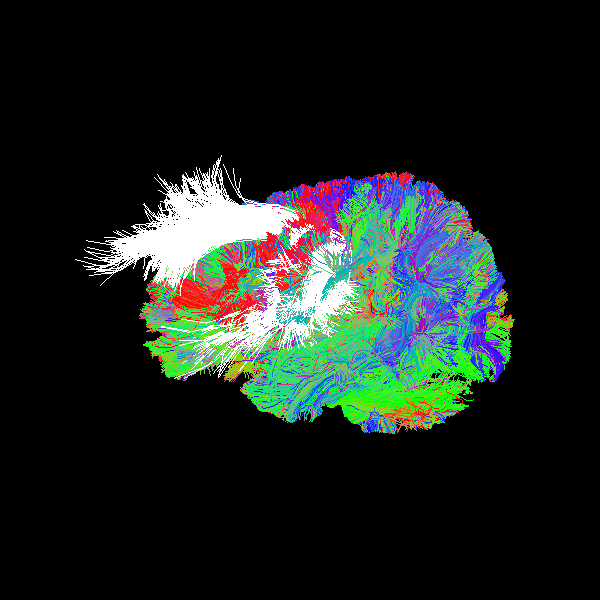

In [51]:
Image(genren(sub_wb_sls, temp_atlasbundle_sls, putpath='pre.png'))

obviously this is incorrect; we need to either
- apply the transform we calculated to the streamline template to bring the template into the patient's space
- apply the inverse transform to the patient's wholebrain streamlines to bring the patient into the template space)

Transform the Atlas bundle template into the subject space using our precomputed affine

In [52]:
temp_atlasbundle_sls_subspace = temp_atlasbundle_tg.copy().apply_affine(xfm_temp2sub).streamlines

After applying registration we can see that the Arcuate bundle template is in the right space (subject-space)

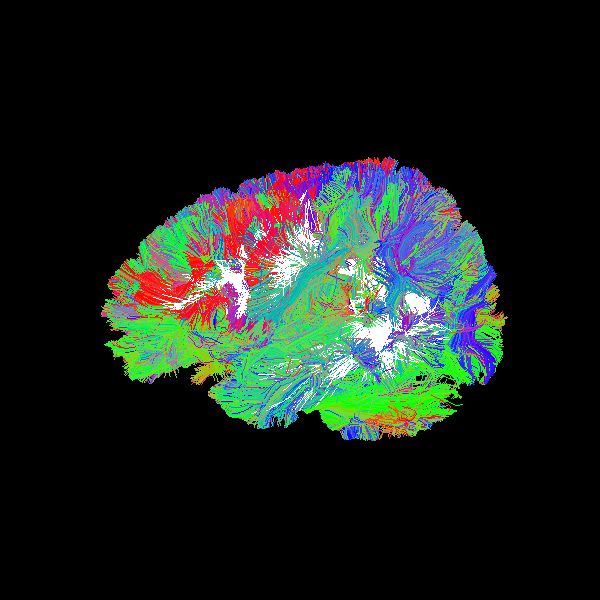

In [53]:
Image(genren(sub_wb_sls, temp_atlasbundle_sls_subspace, putpath='post.png'))

Here's a function to execute recobundles

In [54]:
from dipy.segment.bundles import RecoBundles
from dipy.segment.clustering import qbx_and_merge

def run_rb(templatesls, bucketosls, cluster_map=None, pruning_thr=10):
    # try pruning thresh 10 if not specific drop to 5
    if cluster_map is None:
        cluster_map = qbx_and_merge(bucketosls, 
                                    thresholds=[40, 25, 20, 10])
    else:
        print("Loading provided cluster map")

    rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=5)
    recognized_atlassp, rec_labels, recognized_ptsp = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=5.,
                                                         reduction_thr=10, pruning_thr=pruning_thr)
    return recognized_ptsp, cluster_map

In [55]:
rb_recognized_bundle, cluster_map = run_rb(temp_atlasbundle_sls_subspace, sub_wb_sls, pruning_thr=6)

 Resampled to 20 points
 Size is 12.346 MB
 Duration of resampling is 0.075 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 53941 random streamlines
 Duration 2.777 sec. 

 Streamlines have 1905 centroids
 Total loading duration 0.001 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 987 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.226 MB
 Duration of resampling is 0.006 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.040 sec. 

 Model bundle has 103 centroids
 Duration 0.047 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 1195
 Duration 0.211 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 5.778
 Number of iterations 65
 Matrix size (4, 4)
[[ 0.824 -0.031  0.02  -8.993]
 [ 0.029  0.822  0.069 -8.307]
 [-0.023 -0.069  0.

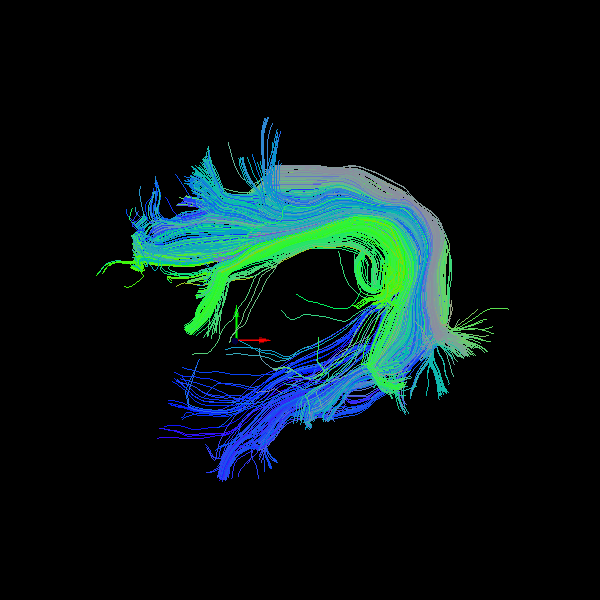

In [56]:
Image(genren(rb_recognized_bundle, putpath='recobundles.png', interact=False))

Now try playing with the pruning threshold in run_rb. What does this do?